## CatBoost Modeling

We have established CatBoost as the top performer among our classification models on the numerical data. It has the additional benefit of being able to accept categorical features without one hot encoding.

In [1]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import label_binarize
from itertools import cycle

import warnings
import os
import time
import math
import requests

import pandas as pd
import numpy as np

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('EPL_Updated.csv')

In [3]:
df.columns

Index(['week', 'date', 'home_team', 'home_xg', 'score', 'away_xg', 'away_team',
       'referee', 'game_id', 'home_team_elo', 'away_team_elo', 'season',
       'home_starters', 'away_starters', 'Bet365 Home Win Odds',
       'Bet365 Draw Odds', 'Bet365 Away Win Odds', 'Bet&Win Home Win Odds',
       'Bet&Win Draw Odds', 'Bet&Win Away Win Odds',
       'Interwetten Home Win Odds', 'Interwetten Draw Odds',
       'Interwetten Away Win Odds', 'Pinnacle Home Win Odds',
       'Pinnacle Draw Odds', 'Pinnacle Away Win Odds',
       'William Hill Home Win Odds', 'William Hill Draw Odds',
       'William Hill Away Win Odds', 'VC Bet Home Win Odds',
       'VC Bet Draw Odds', 'VC Bet Away Win Odds',
       'Pinnacle Closing Home Win Odds', 'Pinnacle Closing Draw Odds',
       'Pinnacle Closing Away Win Odds', 'home_xG_to_date', 'away_xG_to_date',
       'home_xG_against_to_date', 'away_xG_against_to_date',
       'home_goals_scored', 'away_goals_scored', 'home_goals_scored_to_date',
       'awa

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2280 entries, 0 to 2279
Data columns (total 53 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   week                            2280 non-null   int64  
 1   date                            2280 non-null   object 
 2   home_team                       2280 non-null   object 
 3   home_xg                         2280 non-null   float64
 4   score                           2280 non-null   object 
 5   away_xg                         2280 non-null   float64
 6   away_team                       2280 non-null   object 
 7   referee                         2280 non-null   object 
 8   game_id                         2280 non-null   object 
 9   home_team_elo                   2280 non-null   float64
 10  away_team_elo                   2280 non-null   float64
 11  season                          2280 non-null   int64  
 12  home_starters                   22

In [5]:
columns_to_drop = ['week', 'date','home_xg', 'score', 'away_xg','game_id',
                   'season','home_match_points', 'away_match_points', 'match_points',
                   'home_goals_scored', 'away_goals_scored', 'home_starters', 'away_starters', 'Bet365 Home Win Odds',
       'Bet365 Draw Odds', 'Bet365 Away Win Odds', 'Bet&Win Home Win Odds',
       'Bet&Win Draw Odds', 'Bet&Win Away Win Odds',
       'Interwetten Home Win Odds', 'Interwetten Draw Odds',
       'Interwetten Away Win Odds', 'Pinnacle Home Win Odds',
       'Pinnacle Draw Odds', 'Pinnacle Away Win Odds',
       'William Hill Home Win Odds', 'William Hill Draw Odds',
       'William Hill Away Win Odds', 'VC Bet Home Win Odds',
       'VC Bet Draw Odds', 'VC Bet Away Win Odds']

In [24]:
df_model = df.drop(columns=columns_to_drop)

# Display the first few rows of the dataframe after dropping the columns
df_model.tail()

,home_team,away_team,referee,home_team_elo,away_team_elo,Pinnacle Closing Home Win Odds,Pinnacle Closing Draw Odds,Pinnacle Closing Away Win Odds,home_xG_to_date,away_xG_to_date,...,away_xG_against_to_date,home_goals_scored_to_date,away_goals_scored_to_date,home_goals_conceded_to_date,away_goals_conceded_to_date,home_points_to_date,away_points_to_date,home_form,away_form,match_result
2275,everton,bournemouth,Stuart Attwell,1698.783569,1662.989624,1.65,4.26,5.31,44.3,37.8,...,62.7,33,37,57,70,33,39,1.0,1.2,0
2276,leeds united,tottenham,Anthony Taylor,1664.983643,1802.854126,2.80,3.95,2.39,46.0,55.1,...,48.0,47,66,74,62,31,57,0.4,0.8,2
2277,leicester city,west ham,Simon Hooper,1713.210815,1776.454712,2.11,4.01,3.29,49.1,47.8,...,51.6,49,41,67,53,31,40,0.6,1.2,0
2278,manchester utd,fulham,Robert Jones,1866.215576,1736.953369,1.49,5.09,6.14,64.6,44.5,...,60.8,56,54,42,51,72,52,1.8,1.4,0
2279,southampton,liverpool,Darren England,1616.916626,1950.095703,5.77,4.87,1.53,36.1,68.5,...,49.1,32,71,69,43,24,66,0.0,2.6,1


In [7]:
# Assuming df_dropped is your DataFrame after dropping columns

# Define the target variable and the feature set
X = df_model.drop('match_result', axis=1)
y = df_model['match_result']

# Identify categorical features for CatBoost
categorical_features_indices = list(X.select_dtypes(include=['object']).columns)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Separate numerical features
numerical_features = X.select_dtypes(exclude=['object'])

# Initialize the StandardScaler
scaler = StandardScaler()

# Standardize the numerical features using only the training data
X_train[numerical_features.columns] = scaler.fit_transform(X_train[numerical_features.columns])

# Use the same scaling parameters to scale the numerical features in the testing data
X_test[numerical_features.columns] = scaler.transform(X_test[numerical_features.columns])

# Initialize CatBoostClassifier
catboost_model = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    depth=3,
    cat_features=categorical_features_indices,
    verbose=10
)

# Train CatBoostClassifier
catboost_model.fit(X_train, y_train)

# Predict on the testing set
y_pred = catboost_model.predict(X_test)

# Calculate the F1 score
f1 = f1_score(y_test, y_pred, average='weighted')  # Use 'weighted' if classes are imbalanced
print(f'The F1 score of the CatBoost model is: {f1}')


0:	learn: 1.0795237	total: 58.7ms	remaining: 5.81s
10:	learn: 0.9958913	total: 79.1ms	remaining: 640ms
20:	learn: 0.9686231	total: 91.7ms	remaining: 345ms
30:	learn: 0.9568625	total: 105ms	remaining: 233ms
40:	learn: 0.9468430	total: 117ms	remaining: 169ms
50:	learn: 0.9394063	total: 129ms	remaining: 124ms
60:	learn: 0.9343136	total: 141ms	remaining: 90.1ms
70:	learn: 0.9296598	total: 152ms	remaining: 62.2ms
80:	learn: 0.9244191	total: 163ms	remaining: 38.3ms
90:	learn: 0.9201452	total: 174ms	remaining: 17.2ms
99:	learn: 0.9152412	total: 184ms	remaining: 0us
The F1 score of the CatBoost model is: 0.4634499595764917


In [8]:


# Assuming X and y are already defined and categorical features are properly handled

# Create a CatBoost classifier instance
catboost = CatBoostClassifier(cat_features=categorical_features_indices, verbose=0)

# Define the pipeline
pipeline = Pipeline([
    ('classifier', catboost)
])

# Define the hyperparameters grid to be tested
params_grid = {
    'classifier__iterations': [25, 50, 100],
    'classifier__depth': [5, 6, 7, 8],
    'classifier__learning_rate': [ 0.1, 0.2, 0.3, 0.4]
    # You can add other parameters you want to tune
}

# Setup the GridSearchCV object
grid_search = GridSearchCV(pipeline, params_grid, cv=5, scoring='f1_weighted', n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Best hyperparameters
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

# Predict on the testing set using the best estimator
y_pred = best_estimator.predict(X_test)

# Calculate the F1 score with the best estimator
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Best parameters: {best_params}')
print(f'Best F1 score: {f1}')


Best parameters: {'classifier__depth': 7, 'classifier__iterations': 50, 'classifier__learning_rate': 0.2}
Best F1 score: 0.4692383879693265


In [9]:
# Get feature importances from the best estimator
feature_importances = best_estimator.named_steps['classifier'].get_feature_importance()

# Get feature names
feature_names = X_train.columns

# Create a DataFrame to display feature importances
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame to show the most important features at the top
importances_df.sort_values(by='Importance', ascending=False, inplace=True)

print(importances_df)


                           Feature  Importance
3                    home_team_elo   11.602554
1                        away_team    9.956550
4                    away_team_elo    9.456074
18                       home_form    8.714476
19                       away_form    6.930214
5   Pinnacle Closing Home Win Odds    6.778287
6       Pinnacle Closing Draw Odds    6.070083
0                        home_team    4.457597
11         away_xG_against_to_date    4.434637
7   Pinnacle Closing Away Win Odds    4.291537
14     home_goals_conceded_to_date    4.228927
16             home_points_to_date    3.396187
9                  away_xG_to_date    3.277203
15     away_goals_conceded_to_date    3.264793
2                          referee    2.823060
17             away_points_to_date    2.822775
10         home_xG_against_to_date    2.152309
8                  home_xG_to_date    2.101217
13       away_goals_scored_to_date    1.712442
12       home_goals_scored_to_date    1.529079


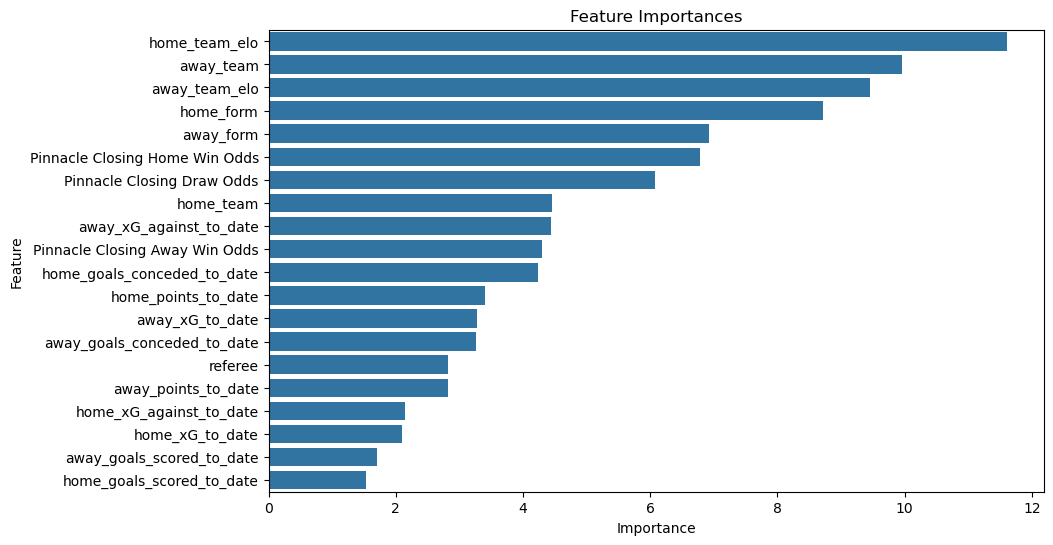

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure your DataFrame 'importances_df' is defined as in your provided code

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=importances_df, x='Importance', y='Feature')

# Add plot labels and title
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')

# Show the plot
plt.show()


In [11]:
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# Assuming X_train, X_test, y_train, y_test, and categorical_features_indices are already defined

# Create a CatBoost classifier instance
catboost = CatBoostClassifier(cat_features=categorical_features_indices, verbose=0)

# Define the pipeline
pipeline = Pipeline([
    # Here you can add other preprocessing steps if needed
    ('classifier', catboost)
])

# Define the hyperparameters grid to be tested
params_grid = {
    'classifier__iterations': [25, 50, 100],
    'classifier__depth': [5, 6, 7, 8],
    'classifier__learning_rate': [0.1, 0.2, 0.3, 0.4]
    # You can add other parameters you want to tune
}

# Setup the GridSearchCV object
grid_search = GridSearchCV(pipeline, params_grid, cv=5, scoring='f1_weighted', n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Best hyperparameters and estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

# Predict on the testing set using the best estimator
y_pred = best_estimator.predict(X_test)

# Calculate various scores with the best estimator
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print the best parameters and all scores
print(f'Best parameters: {best_params}')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Print the full classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Best parameters: {'classifier__depth': 7, 'classifier__iterations': 50, 'classifier__learning_rate': 0.2}
Accuracy: 0.5285
Precision: 0.4394
Recall: 0.5285
F1 Score: 0.4692

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.76      0.64       195
           1       0.11      0.02      0.03       110
           2       0.53      0.60      0.56       151

    accuracy                           0.53       456
   macro avg       0.40      0.46      0.41       456
weighted avg       0.44      0.53      0.47       456



In [12]:
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

# Assuming X_train, X_test, y_train, y_test, and categorical_features_indices are already defined

# Create a CatBoost classifier instance
catboost = CatBoostClassifier(cat_features=categorical_features_indices, verbose=0)

# Define the pipeline
pipeline = Pipeline([
    # Here you can add other preprocessing steps if needed
    ('classifier', catboost)
])

# Define the hyperparameters grid to be tested
params_grid = {
    'classifier__iterations': [25, 50, 100],
    'classifier__depth': [5, 6, 7, 8],
    'classifier__learning_rate': [0.1, 0.2, 0.3, 0.4]
    # You can add other parameters you want to tune
}

# Setup the GridSearchCV object
grid_search = GridSearchCV(pipeline, params_grid, cv=5, scoring='f1_weighted', n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Best hyperparameters and estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

# Predict on the testing set using the best estimator
y_pred = best_estimator.predict(X_test)

# Calculate various scores with the best estimator
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Calculate class-wise accuracy
class_wise_accuracy = cm.diagonal() / cm.sum(axis=1)

# Print the best parameters and all scores
print(f'Best parameters: {best_params}')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Print class-wise accuracy
print("\nClass-wise Accuracy:")
for i, accuracy in enumerate(class_wise_accuracy):
    print(f'Class {i} Accuracy: {accuracy:.4f}')

# Print the full classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Best parameters: {'classifier__depth': 7, 'classifier__iterations': 50, 'classifier__learning_rate': 0.2}
Accuracy: 0.5285
Precision: 0.4394
Recall: 0.5285
F1 Score: 0.4692

Class-wise Accuracy:
Class 0 Accuracy: 0.7590
Class 1 Accuracy: 0.0182
Class 2 Accuracy: 0.6026

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.76      0.64       195
           1       0.11      0.02      0.03       110
           2       0.53      0.60      0.56       151

    accuracy                           0.53       456
   macro avg       0.40      0.46      0.41       456
weighted avg       0.44      0.53      0.47       456



In [13]:
cm

array([[148,   5,  42],
       [ 69,   2,  39],
       [ 48,  12,  91]])

In [14]:
# Assuming the best_estimator from the GridSearchCV is already trained and available

# Predicting probabilities for each class for each record in the test set
class_probabilities = best_estimator.predict_proba(X_test)

# Displaying the first few records of the probabilities
print(class_probabilities[:5])


[[0.50508976 0.29326633 0.20164391]
 [0.42381154 0.27367006 0.3025184 ]
 [0.44534442 0.2662506  0.28840498]
 [0.32032904 0.36157005 0.31810091]
 [0.31834794 0.29146106 0.39019101]]


In [20]:
probability_df = pd.DataFrame(class_probabilities, columns=['Probability_Home_win', 'Probability_Draw', 'Probability_Away_win'])

# Create a new column in X_test to store the original index values
X_test['original_index'] = X_test.index

# Reset the index of X_test
X_test_reset = X_test.reset_index(drop=True)

# Create the probability DataFrame
probability_df = pd.DataFrame(class_probabilities, columns=['Probability_Home_win', 'Probability_Draw', 'Probability_Away_win'])

# Concatenate the reset X_test DataFrame and the probability DataFrame
result_df = pd.concat([X_test_reset, probability_df], axis=1)

# Displaying the first few records of the resulting DataFrame
result_df


,home_team,away_team,referee,home_team_elo,away_team_elo,Pinnacle Closing Home Win Odds,Pinnacle Closing Draw Odds,Pinnacle Closing Away Win Odds,home_xG_to_date,away_xG_to_date,...,home_goals_conceded_to_date,away_goals_conceded_to_date,home_points_to_date,away_points_to_date,home_form,away_form,original_index,Probability_Home_win,Probability_Draw,Probability_Away_win
0,southampton,brighton,Mike Dean,-0.759070,-1.304623,-0.515725,-0.573132,0.047304,0.099504,-0.268957,...,0.547061,0.429505,-0.192244,-0.147575,0.506521,-0.238349,247,0.505090,0.293266,0.201644
1,chelsea,everton,Darren England,0.931987,-0.593049,0.576794,-0.391864,-0.638805,0.410284,0.287586,...,0.018077,0.722634,0.601927,-0.041412,-0.508190,-0.238349,2166,0.423812,0.273670,0.302518
2,leeds united,everton,Darren England,0.170992,0.204638,-0.397402,-0.514659,-0.277695,-1.442443,-1.334167,...,-1.216217,-1.446522,-1.357027,-1.209207,-1.522900,-1.501418,1533,0.445344,0.266251,0.288405
3,fulham,aston villa,Michael Oliver,-0.836720,-0.285266,-0.050320,-0.543896,-0.514423,-0.785023,-0.801562,...,-0.334578,-0.743012,-0.721691,-0.890717,0.252843,0.266879,2004,0.320329,0.361570,0.318101
4,west ham,manchester utd,Peter Bankes,0.015037,0.805207,0.190271,-0.374322,-0.598682,1.169304,1.729808,...,1.428699,0.839886,0.443093,1.975689,-0.000834,0.772106,2243,0.318348,0.291461,0.390191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451,chelsea,leicester city,Lee Probert,0.949234,-0.591883,-0.716875,0.631427,1.100543,0.183176,-0.221082,...,-0.687233,-0.274005,0.601927,-0.200657,0.506521,0.266879,554,0.693173,0.190158,0.116669
452,leicester city,everton,Craig Pawson,0.088098,-0.438217,-0.164699,-0.643301,-0.442201,0.840595,0.652629,...,1.663803,1.719274,0.866650,0.330159,0.252843,1.024720,1869,0.288173,0.370563,0.341264
453,liverpool,burnley,Andre Marriner,1.670679,-0.884886,-0.783925,2.216065,2.416589,1.760982,0.682551,...,-0.628458,1.602022,2.349102,0.223996,2.282263,0.266879,678,0.841485,0.100067,0.058448
454,fulham,crystal palace,Mike Dean,-1.008091,-0.510663,-0.212029,-0.596522,-0.428157,-1.472325,-1.477791,...,-1.510096,-1.505148,-1.357027,-1.368451,-1.522900,-1.501418,382,0.488599,0.222061,0.289340


In [21]:
test_predicted_prob = result_df[['original_index','home_team','away_team','Probability_Home_win', 'Probability_Draw', 'Probability_Away_win']]

In [22]:
test_predicted_prob

,original_index,home_team,away_team,Probability_Home_win,Probability_Draw,Probability_Away_win
0,247,southampton,brighton,0.505090,0.293266,0.201644
1,2166,chelsea,everton,0.423812,0.273670,0.302518
2,1533,leeds united,everton,0.445344,0.266251,0.288405
3,2004,fulham,aston villa,0.320329,0.361570,0.318101
4,2243,west ham,manchester utd,0.318348,0.291461,0.390191
...,...,...,...,...,...,...
451,554,chelsea,leicester city,0.693173,0.190158,0.116669
452,1869,leicester city,everton,0.288173,0.370563,0.341264
453,678,liverpool,burnley,0.841485,0.100067,0.058448
454,382,fulham,crystal palace,0.488599,0.222061,0.289340


In [23]:
csv_file_path = '/Users/lkimball/Desktop/Flatiron/CapstoneProject/test_predicted_prob.csv'
test_predicted_prob.to_csv(csv_file_path, index=True)